In [1]:
# !pip install open3d

Why do we need Open3D?



**Note**: If you are going to run the notebook, make sure you have OpenCV >= 4.4.<br>
OpenCV >= 4.4 because lots of solutions depend on SIFT detector, which is not available before OpenCV 4.4.

In [2]:
import numpy as np
import open3d as o3d
import time
import cv2
from matplotlib import pyplot as plt


In [3]:
cv2.__version__

'4.9.0'

# 1. RANSAC Plane Fitting

RANSAC stands for RANdom SAmple Consensus. It is an iterative algorithm used for fitting models to data containing outliers.

What is the one reason why we want to remove outliers?

The general idea behind RANSAC is as follows:-
  
1.   Iteratively select a subset of the data
2.   Estimate the parameters of the model using this subset
3.   Evaluate the quality of the model by counting how many data points are consistent with it within a certain tolerance threshold
4.   At the end, the model that best fits the majority of the data points or also called as the inliers is chosen as the final model.


It is particularly useful for tasks such as line fitting, plane fitting, and estimating geometric transformations in the presence of outliers.

## Load Point Cloud

1. **Load** the point cloud

In [4]:
#TODO: read pointcloud record_00348.pcd
pcd = o3d.io.read_point_cloud('record_00348.pcd')

## RANSAC without Adaptive Sampling

2. **RANSAC** without adaptive sampling to segment a plane.
    1. Let `N = 1000` and `s = 3` as 3 points can uniquely define a plane.
    2. While `N < 1000`, repeat:
        - Randomly sample 3 points out of the points cloud. Name them `p_1, p_2, p_3`
        - Construct the plane that's uniquely defined by these three points
            1. Construct 2 vector `v_1 = p_3-p_1` and `v_2 = p_2-p_1`. These two vectors lie on the plane these three points defined.
            2. With some simple linear algebra and multi-calculus knowledge, we know the normalized `v_1 × v_2` gives the unit normal to the plane these points lie on.<br>     
        - Calculate all the distance between the plane we just defined and all the points (stored as `points`) in the plane cloud.
            1. With some simple linear algebra we know that if we construct a vector v by (any point in the 3d space - any point on the plane) the dot product of (v, unit normal vector) would be the distance between that 3d point and the plane. The derivation can be found here: https://mathworld.wolfram.com/Point-PlaneDistance.html
            2. Even more conveniently, `points` are currently `n x 3` matrix, so we can utlize the faster Numpy matrix operation and calculate all the distances in one go
            3. `points-p_1` gives the vector we need for all the points in the point cloud.
            4. Then compute the dot product between the unit normal and all the vector we just calculated, essentially giving us the distance between all the points and the plane we just defined, store as a vector. We then find the absolute value of these distances.
        - count the number of inliners using the distance just calculated and the threshold using `np.where`
        - If the current size of inliners is larger than ever seen, record the all the indices of inliners in this step.
    3. Report the indices of points in the largest set of inliners. Because these points will most likely be a plane (the largest plane actually) in the point cloud.
    4. The algorithm can segment out a (largest) plane because, if the plane defined by the random three points is not a plane in the point cloud, it would not have as many inliners.

In [ ]:
def my_RANSAC(points, dist_threshold, num_iter=1000):
    '''
    Input:
    points - np.array. An array of 3-dimensional array of points coordinate
    dist_threshold - float. Threshold to determine inliner/outliner

    Output:
    largest_inliner - list. A list of indices of points that make up the plane we segemented out.
                      Manipulating only indices save memory and time

    Description:
    Use RANSAC algorithm to segment a plane from the point cloud.
    '''

    # parameters to do adaptive sampling
    N = 0 # number of iteration
    num_point = points.shape[0]  # what does this line do?


    largest_inliner_size = 0 # largest size of set of inliner so far, which is 0 at initiation
    largest_inliner = list() # largest set indices of inliners so far, which is empty at initiation

    while N < num_iter:
        inliners = list() # the list to store inliners's indices

        # randomly select 3 points since 3 points define a plane
        p1, p2, p3 = points[np.random.choice(num_point, size=3, replace=False)]


        '''
        This parts describes how we instantiate a model given randomly sampled data point. It can be changed depending on the problem
        '''
        # 2 vectors that would lie on this plane
        v1 = p3 - p1
        v2 = p2 - p1

        # the cross product of the two vector would be the normal vector
        # TODO: how to calculate normalized cross product
        # normal = # TODO: cross product of the two vectors
        # normal = # TODO: normalize the normal
        normal = np.cross(v1, v2)
        normal = normal/np.linalg.norm(normal)

        '''
        Ends here
        '''

        # TODO: fill in the arguments of the np.dot function
        dists = np.abs(np.dot(points-p1, normal)) # get distances between all points and the plane
        inliners = np.where(dists <= dist_threshold)[0] # get indices of those that's within threshold

        # the updating procedure for adaptive sampling
        curr_inliner_size = float(len(inliners)) # the size of current set of inliners

        if curr_inliner_size >= largest_inliner_size:
            largest_inliner = inliners
            largest_inliner_size = len(largest_inliner)

        N = N+1

    return largest_inliner

## Visualize the Plane

3. Using the indices I got from step 2, select all the points that my algorithm thinks make up a plane.
4. Use `o3d.geometry.PointCloud()` to create a Open3D point cloud object and `o3d.utility.Vector3dVector` to put the points I just selected into it.
5. Visualize the original point cloud and my point cloud with a different color so we can see the plane.

In [ ]:
points = np.asarray(pcd.points) #point cloud to np array

start_time = time.time()

my_plane_indices = my_RANSAC(points, 0.01, 1000)
my_plane_points = points[my_plane_indices]
my_cloud = o3d.geometry.PointCloud()
my_cloud.points = o3d.utility.Vector3dVector(my_plane_points)
print("My RANSAC without adptive sampling finds the plane in: %s seconds" % (time.time() - start_time))
my_cloud.paint_uniform_color([1.0, 0, 0])

# TODO: save my_cloud as RANSAC_basic.pcd

#o3d.visualization.draw_geometries([my_cloud, pcd])

My RANSAC without adptive sampling finds the plane in: 19.88076663017273 seconds


True

In [ ]:
start_time = time.time()
plane_model, plane_points = pcd.segment_plane(0.01, 3, 1000)
inlier_cloud = pcd.select_by_index(plane_points)
print("Open3D's built-in method, which doesn't have adaptive sampling and uses max iteration of 1000, takes: %s seconds"
      % (time.time() - start_time))
inlier_cloud.paint_uniform_color([1.0, 0, 0])
o3d.io.write_point_cloud('RANSAC_basic_open3d.pcd', inlier_cloud)
#o3d.visualization.draw_geometries([inlier_cloud, pcd])

Open3D's built-in method, which doesn't have adaptive sampling and uses max iteration of 1000, takes: 0.1599292755126953 seconds


True

## RANSAC + Adaptive Sampling

Could you guess what Adaptive Sampling will perhaps deal with?

2. **RANSAC** with adaptive sampling to segment a plane.
    1. Let `N = ∞` and `sample_count = 0`. `s = 3` as 3 points can uniquely define a plane.
    2. While `N > sample_count`, repeat:
        - Randomly sample 3 points out of the points cloud. Name them `p_1, p_2, p_3`
        - Construct the plane that's uniquely defined by these three points
            1. Construct 2 vector `v_1 = p_3-p_1` and `v_2 = p_2-p_1`. These two vectors lie on the plan these three points defined.
            2. With some simple linear algebra and multi-calculus knowledge, we know the normalized `v_1 × v_2` gives the unit normal to the plane these points lie on.    
        - Calculate all the distance between the plane we just defined and all the points (stored as `points`) in the plane cloud.
            1. With some simple linear algebra we know that if we construct a vector v by (any point in the 3d space - any point on the plane) the dot product of (v, unit normal vector) would be the distance between that 3d point and the plane. The derivation can be found here: https://mathworld.wolfram.com/Point-PlaneDistance.html
            2. Even more conveniently, `points` are currently `n × 3` matrix, so we can utlize the faster Numpy matrix operation and calculate all the distances in one go
            3. `points-p_1` gives the vector we need for all the points in the point cloud.
            4. `np.dot(points-p1, normal)` then compute the dot product between the unit normal and all the vector we just calculated, essentially giving us the distance between all the points and the plane we just defined, store as a vector. We then find the absolute value of these distances.
        - count the number of inliners using the distance just calculated and the threshold using `np.where`

        - ϵ = (number of inliners)/(total number of points)
        
        It is the probability of an individual point being an inlier

        - \begin{equation}
        N = \dfrac{\ln{(1-p)}}{\ln{(1-(1-ϵ)^s)}}
        \end{equation}
        We update `N` in such a way that it will determine the minimum number of iterations required for the algorithm to achieve a certain level of confidence in finding a good model.

        `p` is the probability of success which corresponds to the confidence level of finding a good model.  

        - `sample_count + 1`
        - If the current size of inliners is larger than ever seen, record the all the indices of inliners in this step.

    3. Report the indices of points in the largest set of inliners when the adaptive sampling terminates. Because these points will most likely be a plane (the largest plane actually) in the plane cloud.
    4. The algorithm can segment out a (largest) plane because, if the plane defined by the random three points is not a plane in the point cloud, it would not have as many inliners.

In [ ]:
def my_RANSAC_adaptive(points, dist_threshold):
    '''
    Input:
    points - np.array. An array of 3-dimensional array of points coordinate
    dist_threshold - float. Threshold to determine inliner/outliner

    Output:
    largest_inliner - list. A list of indices of points that make up the plane we segemented out.
                      Manipulating only indices save memory and time
    sample_count - int. An integer of number of iteration. Generated by adaptive sampling

    Description:
    Use RANSAC algorithm to segment a plane from the point cloud.
    Different from open3d's implementation of segment_plane, I will use adaptive sampling to
    determine the number of iteration. So the function does not have the parameter to
    specify the number of iteration
    '''

    # parameters to do adaptive sampling
    N = np.inf # number of iteration
    sample_count = 0
    num_point = points.shape[0]
    s = 3 # since 3 points define a plane, we always sample 3 points
    p = 0.99

    largest_inliner_size = 0 # largest size of set of inliner so far, which is 0 at initiation
    largest_inliner = list() # largest set indices of inliners so far, which is empty at initiation

    while N > sample_count:
        inliners = list() # the list to store inliners's indices

        # randomly select 3 points since 3 points define a plane
        p1, p2, p3 = points[np.random.choice(num_point, size=3, replace=False)]

        # 2 vectors that would lie on this plane
        v1 = p3 - p1
        v2 = p2 - p1

        # the cross product of the two vector would be the normal vector
        normal = np.cross(v1, v2)
        normal = normal/np.linalg.norm(normal)

        dists = np.abs(np.dot(points-p1, normal)) # get distances between all points and the plane
        inliners = np.where(dists <= dist_threshold)[0] # get indices of those that's within threshold

        # the updating procedure for adaptive sampling
        curr_inliner_size = float(len(inliners)) # the size of current set of inliners
        epsilon = 1 - (curr_inliner_size/num_point)
        denominator = 1 - np.power(1-epsilon, s)
        if np.isclose(denominator, 1):
          denominator = 1 - np.finfo(float).eps  # to prevent divide by 0 error
        N = np.log(1-p)/np.log(denominator) # 4.18 from Hartley & Zisserman 2003
        sample_count += 1

        if curr_inliner_size >= largest_inliner_size:
            largest_inliner = inliners
            largest_inliner_size = len(largest_inliner)

    return largest_inliner, sample_count

In [ ]:
points = np.asarray(pcd.points) #point cloud to np array

start_time = time.time()

my_plane_indices, sample_count = my_RANSAC_adaptive(points, 0.01)
my_plane_points = points[my_plane_indices]
my_cloud = o3d.geometry.PointCloud()
my_cloud.points = o3d.utility.Vector3dVector(my_plane_points)
print("My RANSAC with adptive sampling finds the plane in: %s seconds" % (time.time() - start_time))
print(f"And it takes {sample_count} iterations")
my_cloud.paint_uniform_color([1.0, 0, 0])
o3d.io.write_point_cloud('RANSAC_adaptive_sampling.pcd', my_cloud)
#o3d.visualization.draw_geometries([my_cloud, pcd])

My RANSAC with adptive sampling finds the plane in: 0.3073854446411133 seconds
And it takes 14 iterations


True

# 2. RANSAC and SIFT Feature Matching

SIFT stands for Scale-Invariant Feature Transform. It is a feature detection and description algorithm used in computer vision for tasks such as object recognition, image stitching, and 3D reconstruction. SIFT was introduced by David Lowe in 1999 and has since become one of the most widely used algorithms in the field.

Now let's do some SIFT feature matching, and see its synergy with RANSAC

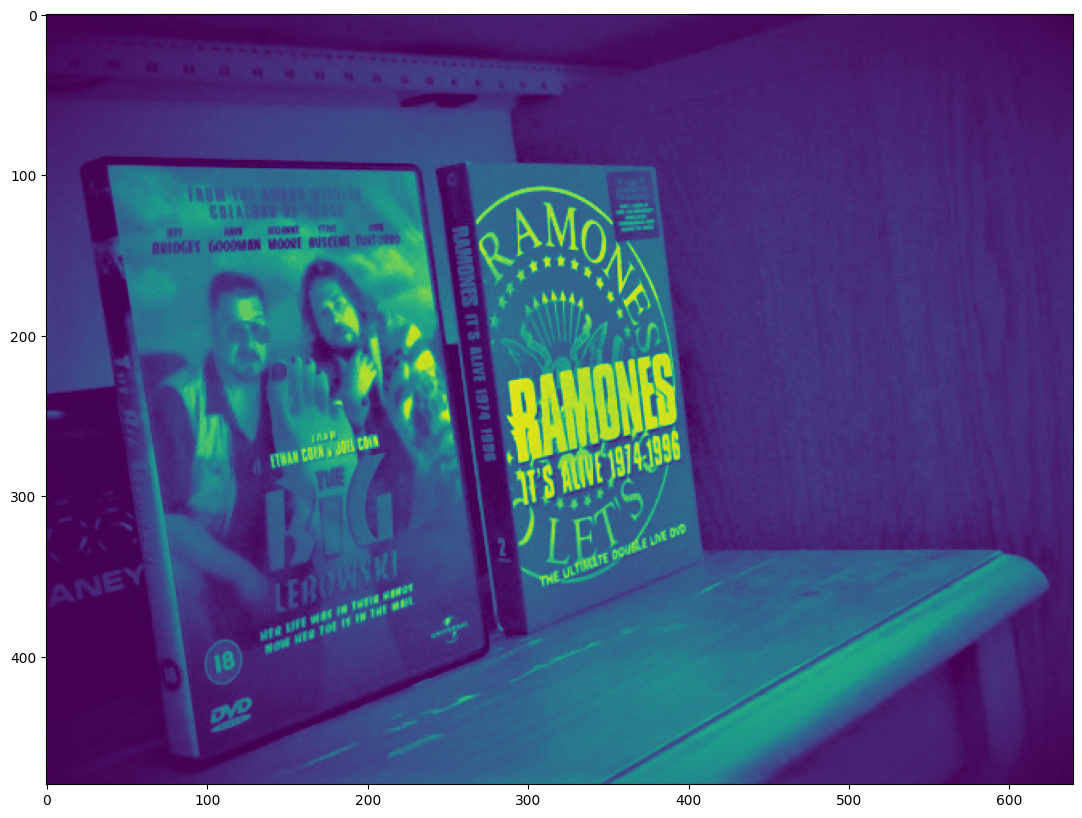

In [ ]:
# Load images
img_left_dist = cv2.imread('image_l.jpg', 0)  # What does the 0 indicate?
img_right_dist = cv2.imread('image_r.jpg', 0)

plt.figure(figsize = (20, 10))
plt.imshow(img_left_dist);

## Feature Detection, Matching and Visualization

Note that in the matching process, after we utlize brute force matching, we conduct ratio test.
The ratio test is proposed by D.Lowe in his paper to be used with KNN matching.

In general, it’s done
like this: each keypoint of the left image is matched with a number of keypoints from the right image
and we only keep the 2 best matches for each keypoint of the left. Smaller the distance, better the
match. Then we only keep a match if for this keypoint its best distance is smaller than 0.75 times the
distance of the second best match.


In [ ]:
def feature_matching(img_left, img_right):
    '''
    Input:
    img_left - An image read by OpenCV's imread
    img_right - An image read by OpenCV's imread

    Output:
    points_left - array of tuples. Each tuple is a coordinate on the left image.
    points_right - array of tuples. Each tuple is a coordinate on the right image.
    '''
    # generate SIFT feature
    feature_detector = cv2.SIFT_create()
    keypoints_left, descriptors_left = feature_detector.detectAndCompute(img_left, None)
    keypoints_right, descriptors_right = feature_detector.detectAndCompute(img_right, None)

    # construct BFMatcher
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors_left,descriptors_right, k=2)

    # apply ratio test
    good_matches = []
    for best, second in matches:
        if best.distance < 0.8*second.distance:
            # here we are converting it to a list to do visualization.
            good_matches.append([best])


    # convert OpenCV's special match class to regular array
    points_left = []
    points_right = []
    for best in good_matches:
        points_left.append(keypoints_left[best[0].queryIdx].pt)
        points_right.append(keypoints_right[best[0].trainIdx].pt)


    # some visualization
    img_matches = cv2.drawMatchesKnn(img_left, keypoints_left,
                                     img_right,keypoints_right,
                                     good_matches[:20],None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize = (20, 10))
    plt.imshow(img_matches);
    return points_left, points_right

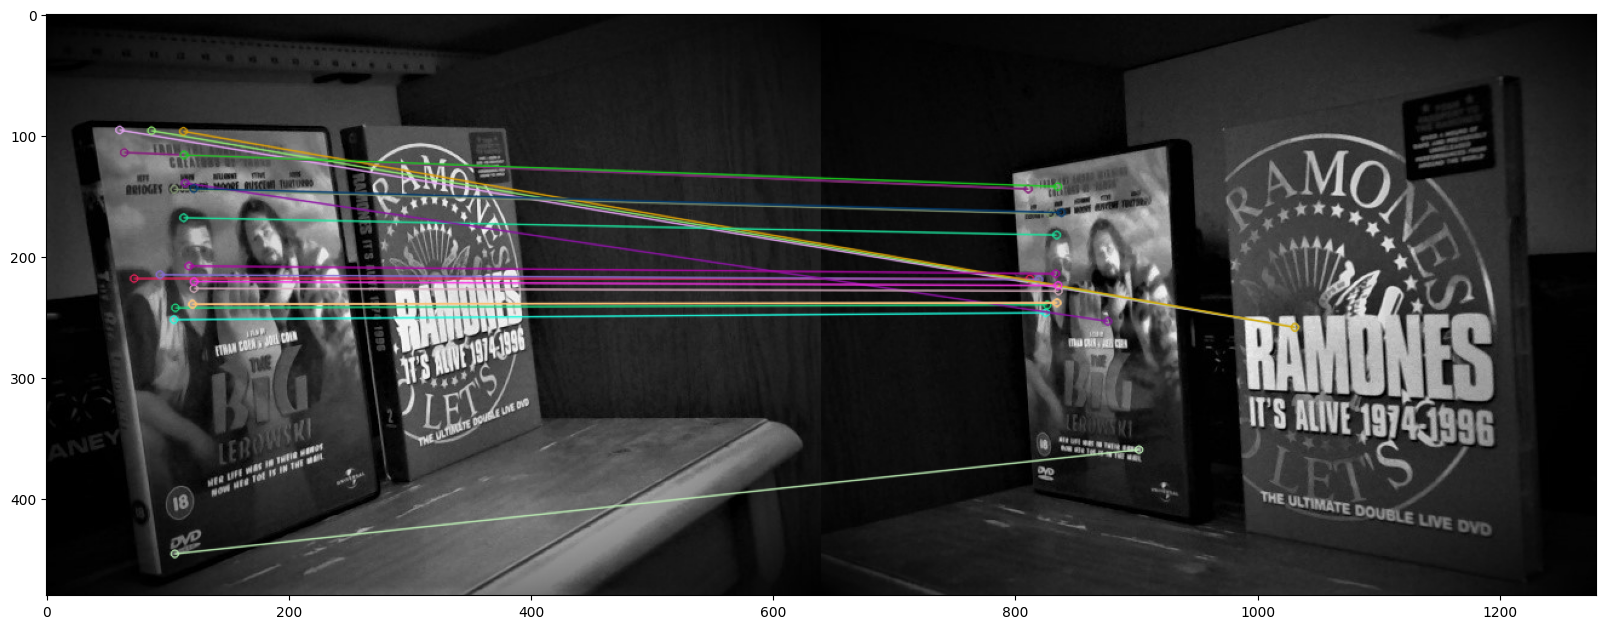

In [ ]:
points_left_dist, points_right_dist = feature_matching(img_left_dist, img_right_dist)

As you can see, we have tons of SIFT matching on these two images. A lot of them are frankly terrible matches. Let's see how they fare when we do fundamental matrix estimation using them.

## Fundamental Matrix Estimation without RANSAC

In [ ]:
ptsLeft = np.int32(points_left_dist)
ptsRight = np.int32(points_right_dist)

# Find the fundamental matrix, use naive 8 point method

# TODO: Find the OpenCV function to compute the fundamental matrix using 8-point method
F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, method=cv2.FM_8POINT)

# We select only inlier points
ptsLeft_dis = ptsLeft[mask.ravel() == 1]
ptsRight_dis = ptsRight[mask.ravel() == 1]

In [ ]:
def drawlines(img1, img2, lines, pts1, pts2):

    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2 in zip(lines, pts1[:60], pts2[:60]):

        color = tuple(np.random.randint(0, 255,
                                        3).tolist())

        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int,
                     [c, -(r[2] + r[0] * c) / r[1] ])

        img1 = cv2.line(img1,
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2,
                          tuple(pt2), 5, color, -1)
    return img1, img2

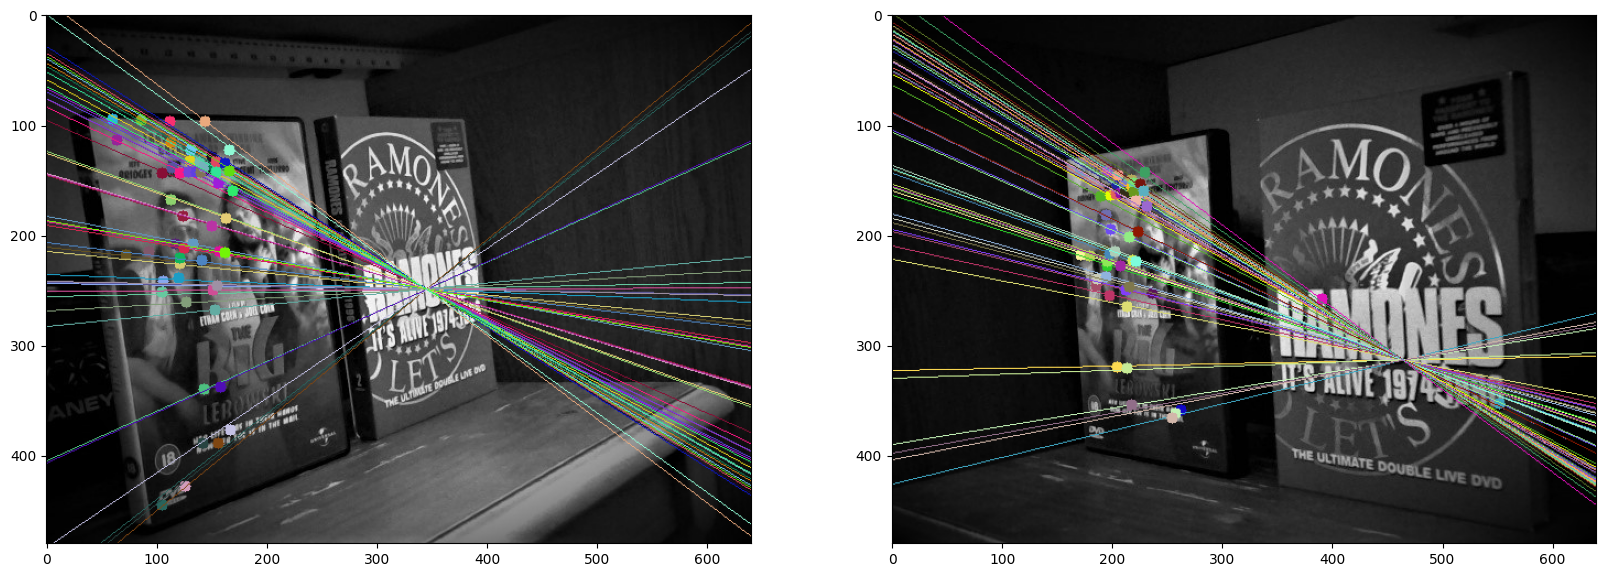

In [ ]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight_dis.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)

img5, img6 = drawlines(img_left_dist, img_right_dist,
                       linesLeft, ptsLeft_dis,
                       ptsRight_dis)

# Find epilines corresponding to
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft_dis.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)

img3, img4 = drawlines(img_right_dist, img_left_dist,
                       linesRight, ptsRight_dis,
                       ptsLeft)
plt.figure(figsize = (20, 10))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

Is the estimation / epipolar lines correct?

If yes, why?

If no, why?

## Fundamental Matrix Estimation with RANSAC

Now let's see if using RANSAC will help.

But firstly, let's think about how we fit this whole fundamental matrix estimation thing inside the RANSAC framework

Essentially, in RANSAC framework, we need to first sample data points, and then use these points to instantiate a model, so we can test the error this model gives for all the other data points.

In our case, we could randomly select 8 points to estimate a fundamental matrix, and then use this fundamental matrix to test on the definition of fundamental matrix, that is $$x'^TFx = 0$$


The error will measure that given two points $x', x$, and our newly estimated matrix $F$, how far away the result is from $0$. The specific implementation of such an error function/cost function is beyond the scope of this class, but I encourage you to look for reprojection error.


With these in mind, we can fit the fundamental matrix estimation into the RANSAC framework.

In [ ]:
ptsLeft = np.int32(points_left_dist)
ptsRight = np.int32(points_right_dist)

# Find the fundamental matrix, use RANSAC method

# TODO: Find the OpenCV function to compute the fundamental matrix using RANSAC algorithm
F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, method=cv2.FM_8POINT, ransacReprojThreshold=0.1)

# We select only inlier points
ptsLeft_dis = ptsLeft[mask.ravel() == 1]
ptsRight_dis = ptsRight[mask.ravel() == 1]

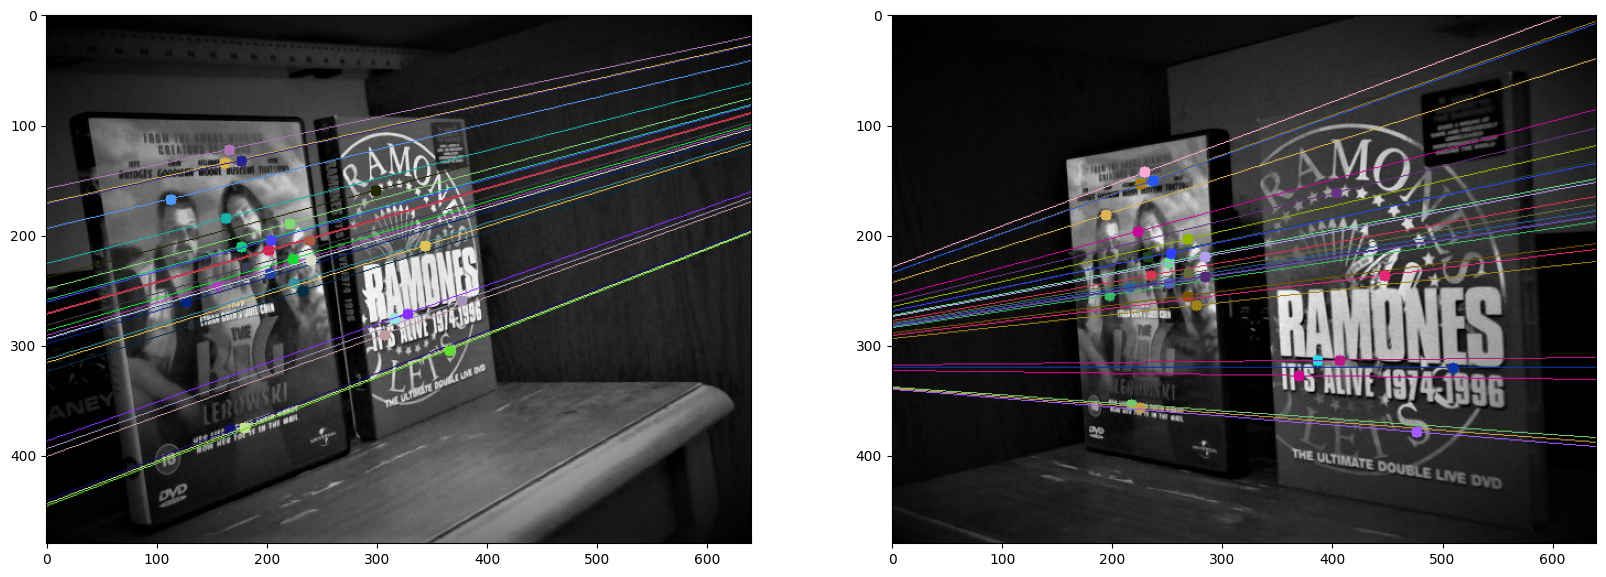

In [ ]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight_dis.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)

img5, img6 = drawlines(img_left_dist, img_right_dist,
                       linesLeft, ptsLeft_dis,
                       ptsRight_dis)

# Find epilines corresponding to
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft_dis.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)

img3, img4 = drawlines(img_right_dist, img_left_dist,
                       linesRight, ptsRight_dis,
                       ptsLeft)
plt.figure(figsize = (20, 10))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

# Homework 7

In the above tutorial, we used OpenCV's SIFT feature extractor to compute the Fundamental Matrix with and without RANSAC.

For this homework, change the SIFT feature extractor to ORB feature extractor (using OpenCV) to perform the same steps i.e. compute the Fundamental Matrix with and without RANSAC.

Upload the following 2 screenshots:-

1.   Epipolar lines obtained from the fundamental matrix computed without RANSAC
2.   Epipolar lines obtained from the fundamental matrix computed with RANSAC

Upload the screenshots of the visualizations to [HW7 Google Form](https://forms.gle/TZ4UqziKpDYAcNtc6).

